# Inspect V-JEPA2 Embeddings

This notebook loads and inspects embeddings extracted by the pipeline described in
[`readme-embeddings.md`](../readme-embeddings.md).

**Sample embeddings:** `data/sample/` (5 videos, included in repo)  
**Full embeddings:** `/orcd/pool/006/lceli_shared/embeddings/` (after running extraction)

| Model | File | embed_dim |
|---|---|---|
| ViT-L | `vitl_embeddings.pt` | 1024 |
| ViT-H | `vith_embeddings.pt` | 1280 |
| ViT-g | `vitg_embeddings.pt` | 1408 |
| ViT-g/384 | `vitg-384_embeddings.pt` | 1408 |

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

matplotlib.rcParams["figure.dpi"] = 120

In [2]:
# Use sample embeddings shipped with the repo (5 videos)
# To inspect full extraction results, change to:
#   EMBEDDINGS_DIR = Path("/orcd/pool/006/lceli_shared/embeddings")
EMBEDDINGS_DIR = Path("../data/sample")

pt_files = sorted(EMBEDDINGS_DIR.glob("*_embeddings.pt"))
print(f"Found {len(pt_files)} embedding file(s) in {EMBEDDINGS_DIR.resolve()}:\n")
for f in pt_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  {f.name:30s}  {size_mb:.2f} MB")

Found 1 embedding file(s) in /orcd/pool/005/sebasmos/code/EchoJEPA-VE/data/sample:

  vitl_embeddings.pt              0.02 MB


## 1. Metadata and health checks

In [3]:
for pt_file in pt_files:
    print("=" * 70)
    print(f"File: {pt_file.name}")
    print("=" * 70)

    data = torch.load(pt_file, map_location="cpu", weights_only=False)

    print(f"  Type:           {type(data).__name__}")
    print(f"  Num videos:     {len(data)}")

    if len(data) == 0:
        print("  (empty)\n")
        continue

    keys = list(data.keys())
    print(f"  Key type:       {type(keys[0]).__name__}")
    print(f"  Sample keys:")
    for k in keys[:5]:
        print(f"    {k}")
    if len(keys) > 5:
        print(f"    ... ({len(keys) - 5} more)")

    sample_emb = data[keys[0]]
    print(f"\n  --- Tensor Info ---")
    print(f"  Shape:          {sample_emb.shape}")
    print(f"  Dtype:          {sample_emb.dtype}")
    print(f"  Device:         {sample_emb.device}")
    print(f"  Requires grad:  {sample_emb.requires_grad}")

    all_embs = torch.stack(list(data.values()))
    print(f"\n  --- Stacked Matrix ---")
    print(f"  Shape:          {all_embs.shape}  (num_videos x embed_dim)")
    print(f"  Memory:         {all_embs.element_size() * all_embs.nelement() / (1024*1024):.2f} MB")

    print(f"\n  --- Statistics ---")
    print(f"  Mean:           {all_embs.mean().item():.6f}")
    print(f"  Std:            {all_embs.std().item():.6f}")
    print(f"  Min:            {all_embs.min().item():.6f}")
    print(f"  Max:            {all_embs.max().item():.6f}")
    print(f"  Median:         {all_embs.median().item():.6f}")

    print(f"\n  --- Health Checks ---")
    print(f"  All finite:     {torch.isfinite(all_embs).all().item()}")
    print(f"  Any NaN:        {torch.isnan(all_embs).any().item()}")
    print(f"  Any Inf:        {torch.isinf(all_embs).any().item()}")
    print(f"  Any all-zero:   {(all_embs.abs().sum(dim=1) == 0).any().item()}")

    dim_means = all_embs.mean(dim=0)
    dim_stds = all_embs.std(dim=0)
    print(f"\n  --- Per-Dimension (across videos) ---")
    print(f"  Dim mean range: [{dim_means.min().item():.4f}, {dim_means.max().item():.4f}]")
    print(f"  Dim std range:  [{dim_stds.min().item():.4f}, {dim_stds.max().item():.4f}]")
    print(f"  Dead dims (std<1e-6): {(dim_stds < 1e-6).sum().item()}")

    norms = all_embs.norm(dim=1)
    print(f"\n  --- Per-Video L2 Norms ---")
    print(f"  Mean norm:      {norms.mean().item():.4f}")
    print(f"  Std norm:       {norms.std().item():.4f}")
    print(f"  Min norm:       {norms.min().item():.4f}")
    print(f"  Max norm:       {norms.max().item():.4f}")
    print()

File: vitl_embeddings.pt
  Type:           dict
  Num videos:     5
  Key type:       str
  Sample keys:
    p10/p10002221/s94106955/94106955_0001.mp4
    p10/p10002221/s94106955/94106955_0006.mp4
    p10/p10002221/s94106955/94106955_0007.mp4
    p10/p10002221/s94106955/94106955_0008.mp4
    p10/p10002221/s94106955/94106955_0009.mp4

  --- Tensor Info ---
  Shape:          torch.Size([1024])
  Dtype:          torch.float32
  Device:         cpu
  Requires grad:  False

  --- Stacked Matrix ---
  Shape:          torch.Size([5, 1024])  (num_videos x embed_dim)
  Memory:         0.02 MB

  --- Statistics ---
  Mean:           0.017205
  Std:            1.750561
  Min:            -24.597710
  Max:            12.266594
  Median:         0.026334

  --- Health Checks ---
  All finite:     True
  Any NaN:        False
  Any Inf:        False
  Any all-zero:   False

  --- Per-Dimension (across videos) ---
  Dim mean range: [-23.0167, 11.4914]
  Dim std range:  [0.0200, 2.5736]
  Dead dims (st

## 2. Summary table (all models)

In [4]:
rows = []
for pt_file in pt_files:
    data = torch.load(pt_file, map_location="cpu", weights_only=False)
    if len(data) == 0:
        continue
    all_embs = torch.stack(list(data.values()))
    norms = all_embs.norm(dim=1)
    rows.append({
        "File": pt_file.name,
        "Videos": len(data),
        "Embed Dim": all_embs.shape[1],
        "Dtype": str(all_embs.dtype),
        "Mean": f"{all_embs.mean().item():.4f}",
        "Std": f"{all_embs.std().item():.4f}",
        "L2 Norm (mean)": f"{norms.mean().item():.2f}",
        "All Finite": torch.isfinite(all_embs).all().item(),
        "Size (MB)": f"{pt_file.stat().st_size / (1024*1024):.2f}",
    })

display(pd.DataFrame(rows))

,File,Videos,Embed Dim,Dtype,Mean,Std,L2 Norm (mean),All Finite,Size (MB)
0,vitl_embeddings.pt,5,1024,torch.float32,0.0172,1.7506,56.01,True,0.02


## 3. Cosine similarity heatmap

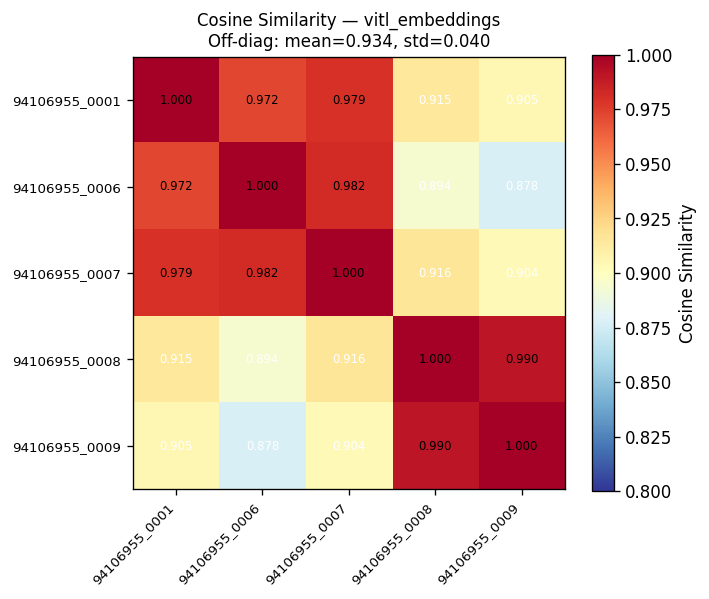

In [5]:
for pt_file in pt_files:
    data = torch.load(pt_file, map_location="cpu", weights_only=False)
    if len(data) < 2:
        print(f"{pt_file.name}: need >= 2 videos, skipping")
        continue

    keys = list(data.keys())
    short_keys = [Path(k).stem for k in keys]
    all_embs = torch.stack(list(data.values()))

    normed = all_embs / all_embs.norm(dim=1, keepdim=True)
    sim = (normed @ normed.T).numpy()

    # Off-diagonal stats
    n = sim.shape[0]
    mask = ~np.eye(n, dtype=bool)
    off_diag = sim[mask]

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(sim, cmap="RdYlBu_r", vmin=min(0.8, off_diag.min()), vmax=1.0)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(short_keys, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(short_keys, fontsize=8)

    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{sim[i,j]:.3f}", ha="center", va="center", fontsize=7,
                    color="white" if sim[i,j] < 0.92 else "black")

    plt.colorbar(im, ax=ax, label="Cosine Similarity")
    ax.set_title(f"Cosine Similarity — {pt_file.stem}\n"
                 f"Off-diag: mean={off_diag.mean():.3f}, std={off_diag.std():.3f}", fontsize=10)
    plt.tight_layout()
    plt.show()

## 4. Embedding distribution

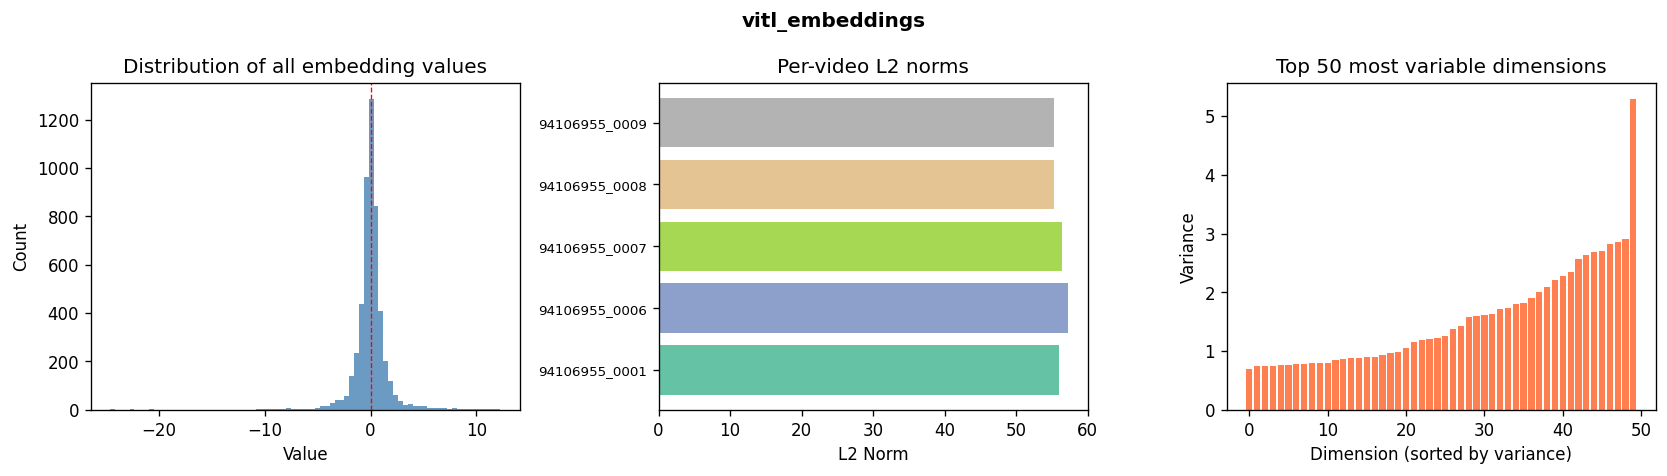

In [6]:
for pt_file in pt_files:
    data = torch.load(pt_file, map_location="cpu", weights_only=False)
    if len(data) == 0:
        continue

    keys = list(data.keys())
    short_keys = [Path(k).stem for k in keys]
    all_embs = torch.stack(list(data.values())).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # (a) Histogram of all embedding values
    axes[0].hist(all_embs.flatten(), bins=80, color="steelblue", edgecolor="none", alpha=0.8)
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Distribution of all embedding values")
    axes[0].axvline(0, color="red", linestyle="--", linewidth=0.8)

    # (b) Per-video L2 norm bar chart
    norms = np.linalg.norm(all_embs, axis=1)
    colors = plt.cm.Set2(np.linspace(0, 1, len(short_keys)))
    axes[1].barh(range(len(short_keys)), norms, color=colors)
    axes[1].set_yticks(range(len(short_keys)))
    axes[1].set_yticklabels(short_keys, fontsize=8)
    axes[1].set_xlabel("L2 Norm")
    axes[1].set_title("Per-video L2 norms")

    # (c) Per-dimension variance (top 50 most variable dims)
    dim_var = all_embs.var(axis=0)
    top_dims = np.argsort(dim_var)[-50:]
    axes[2].bar(range(50), dim_var[top_dims], color="coral", edgecolor="none")
    axes[2].set_xlabel("Dimension (sorted by variance)")
    axes[2].set_ylabel("Variance")
    axes[2].set_title("Top 50 most variable dimensions")

    fig.suptitle(f"{pt_file.stem}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

## 5. PCA projection

Project the high-dimensional embeddings down to 2D using PCA.  
With only 5 sample videos (same patient), points will be close together.  
With the full dataset, clusters should emerge by echo view type or patient.

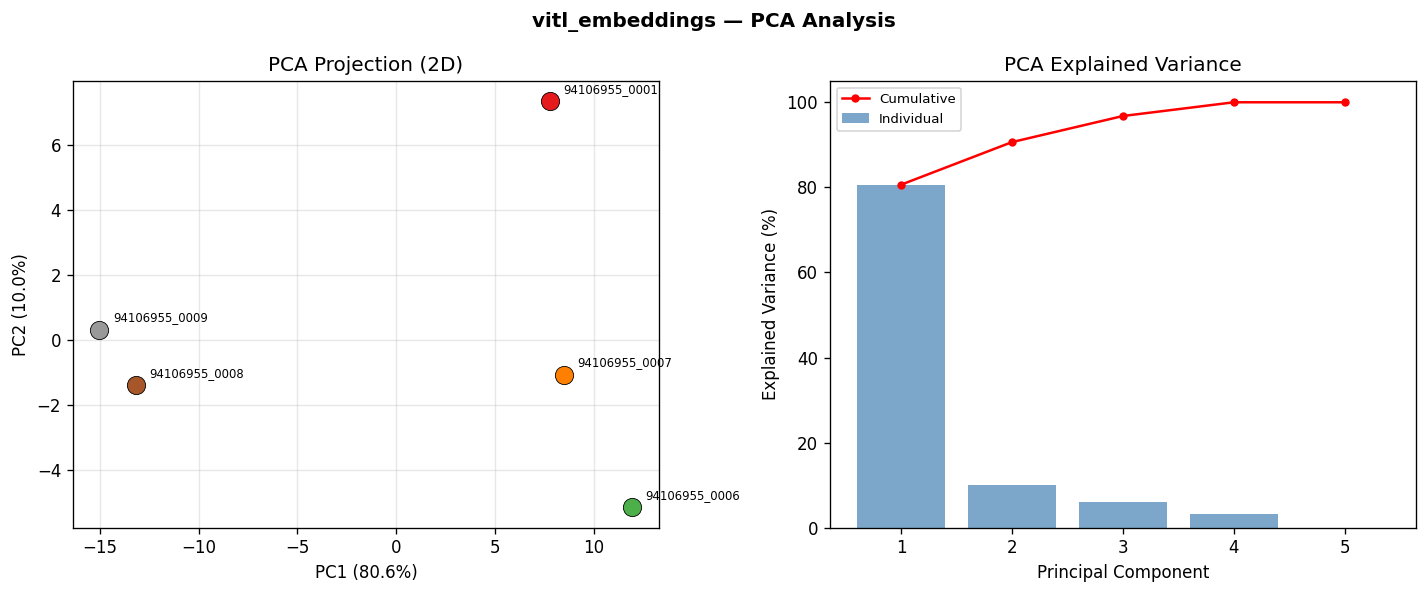

  Explained variance: PC1=80.6%, PC2=10.0%


In [7]:
for pt_file in pt_files:
    data = torch.load(pt_file, map_location="cpu", weights_only=False)
    if len(data) < 3:
        print(f"{pt_file.name}: need >= 3 videos for PCA, skipping")
        continue

    keys = list(data.keys())
    short_keys = [Path(k).stem for k in keys]
    all_embs = torch.stack(list(data.values())).numpy()
    n = len(keys)

    # PCA to 2D
    n_components = min(2, n, all_embs.shape[1])
    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(all_embs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (a) PCA scatter
    colors = plt.cm.Set1(np.linspace(0, 1, n))
    for i in range(n):
        axes[0].scatter(proj[i, 0], proj[i, 1], c=[colors[i]], s=120, edgecolors="black",
                       linewidth=0.5, zorder=3)
        axes[0].annotate(short_keys[i], (proj[i, 0], proj[i, 1]),
                        textcoords="offset points", xytext=(8, 5), fontsize=7)
    axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    axes[0].set_title("PCA Projection (2D)")
    axes[0].grid(True, alpha=0.3)

    # (b) Explained variance
    n_pca_full = min(n, all_embs.shape[1])
    pca_full = PCA(n_components=n_pca_full)
    pca_full.fit(all_embs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_) * 100
    axes[1].bar(range(1, n_pca_full + 1), pca_full.explained_variance_ratio_ * 100,
               color="steelblue", alpha=0.7, label="Individual")
    axes[1].plot(range(1, n_pca_full + 1), cumvar, "ro-", markersize=4, label="Cumulative")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].set_title("PCA Explained Variance")
    axes[1].legend(fontsize=8)
    axes[1].set_ylim(0, 105)

    fig.suptitle(f"{pt_file.stem} — PCA Analysis", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

    print(f"  Explained variance: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, "
          f"PC2={pca.explained_variance_ratio_[1]*100:.1f}%")

## 6. Per-video embedding profiles

Visualize the raw embedding vectors as line plots to see structural patterns.

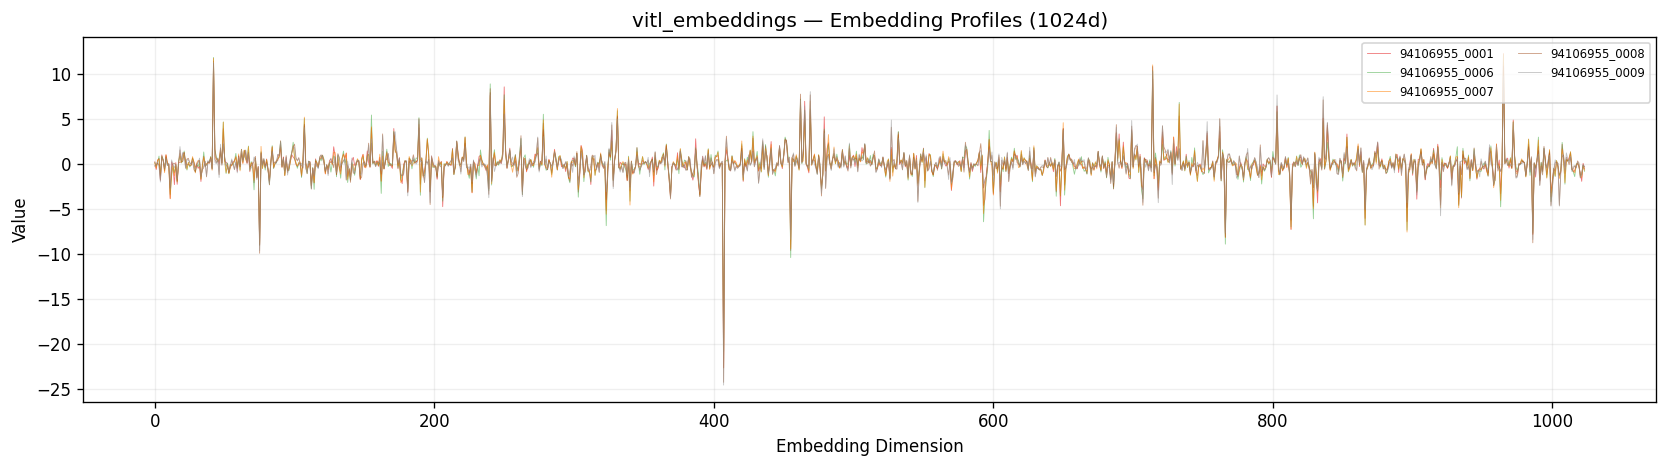

In [8]:
for pt_file in pt_files:
    data = torch.load(pt_file, map_location="cpu", weights_only=False)
    if len(data) == 0:
        continue

    keys = list(data.keys())
    short_keys = [Path(k).stem for k in keys]
    all_embs = torch.stack(list(data.values())).numpy()

    fig, ax = plt.subplots(figsize=(14, 4))
    colors = plt.cm.Set1(np.linspace(0, 1, len(keys)))
    for i, (key, emb) in enumerate(zip(short_keys, all_embs)):
        ax.plot(emb, alpha=0.6, linewidth=0.5, color=colors[i], label=key)

    ax.set_xlabel("Embedding Dimension")
    ax.set_ylabel("Value")
    ax.set_title(f"{pt_file.stem} — Embedding Profiles ({all_embs.shape[1]}d)")
    ax.legend(fontsize=7, loc="upper right", ncol=2)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

## 7. Example: Load embeddings for downstream use

In [9]:
pt_file = pt_files[0]
data = torch.load(pt_file, map_location="cpu", weights_only=False)

first_key = list(data.keys())[0]
first_emb = data[first_key]

print(f"File:      {pt_file.name}")
print(f"Video:     {first_key}")
print(f"Embedding: shape={first_emb.shape}, dtype={first_emb.dtype}")
print(f"Values:    {first_emb[:10].tolist()}  ...")
print(f"\nTo use downstream:")
print(f"  embeddings = torch.load('{pt_file}', map_location='cpu', weights_only=False)")
print(f"  matrix = torch.stack(list(embeddings.values()))  # [{len(data)}, {first_emb.shape[0]}]")

File:      vitl_embeddings.pt
Video:     p10/p10002221/s94106955/94106955_0001.mp4
Embedding: shape=torch.Size([1024]), dtype=torch.float32
Values:    [0.23831862211227417, -0.6252825260162354, 0.41357216238975525, 0.6149054169654846, -1.820011019706726, 1.0015324354171753, 0.3049873113632202, -0.8004064559936523, 0.9947009086608887, 0.06663747131824493]  ...

To use downstream:
  embeddings = torch.load('../data/sample/vitl_embeddings.pt', map_location='cpu', weights_only=False)
  matrix = torch.stack(list(embeddings.values()))  # [5, 1024]
